In [73]:
install.packages("viridis")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [110]:
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install("BSgenome.Hsapiens.UCSC.hg38", force=TRUE)


'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cloud.r-project.org

Bioconductor version 3.21 (BiocManager 1.30.26), R 4.5.1 (2025-06-13)

Installing package(s) 'BSgenome.Hsapiens.UCSC.hg38'

Old packages: 'BiocParallel', 'Rsamtools', 'broom', 'credentials', 'dbplyr',
  'dtplyr', 'ggplot2', 'googledrive', 'magrittr', 'stringr', 'codetools',
  'lattice', 'mgcv', 'spatial'



In [112]:
suppressPackageStartupMessages({
    library(DSS)
    library(bsseq)
    library(dplyr)
    library(data.table)
    library(BiocParallel)
    library(ggplot2)
    library(gridExtra)
    library(scales)
    library(viridis)
    library(rtracklayer)
    library(GenomicRanges)
    library(IRanges)
    library(BSgenome.Hsapiens.UCSC.hg38)
})

In [113]:
genome_build <- "hg38"  # Change this if using a different genome build
cat("Using genome build:", genome_build, "\n")


Using genome build: hg38 


In [114]:
seqinfo_genome <- seqinfo(BSgenome.Hsapiens.UCSC.hg38)


In [115]:
if(genome_build == "hg38") {
  seqinfo_genome <- seqinfo(BSgenome.Hsapiens.UCSC.hg38)
} else if(genome_build == "hg19") {
  seqinfo_genome <- seqinfo(BSgenome.Hsapiens.UCSC.hg19)
}

In [5]:
convert_pacbio_model <- function(file, outfile, min_coverage = 5, verbose = FALSE) {
  if (verbose) message("Reading PacBio file...")
  
  df <- fread(file, header=TRUE)
  setnames(df, gsub("^#", "", colnames(df))) # rename '#chrom' → 'chrom'
  
  required_cols <- c("chrom","begin","end","cov","est_mod_count")
  if (!all(required_cols %in% colnames(df))) {
    stop("PacBio file must contain columns: ", paste(required_cols, collapse=", "))
  }
  
  if (verbose) {
    message("Initial sites: ", nrow(df))
    message("Mean coverage: ", round(mean(df$cov), 2))
  }
  
  dss_df <- df %>%
    mutate(chr = chrom,
           pos = begin + 1,       # convert 0-based to 1-based
           N   = cov,
           X   = est_mod_count) %>%
    filter(N >= min_coverage) %>%  # Apply coverage filter
    select(chr, pos, N, X)
  
  if (verbose) {
    message("Sites after filtering (coverage >= ", min_coverage, "): ", nrow(dss_df))
    message("Mean methylation rate: ", round(mean(dss_df$X / dss_df$N), 3))
  }
  
  write.table(dss_df, file=outfile, sep="\t", quote=FALSE,
              row.names=FALSE, col.names=TRUE)
  
  return(nrow(dss_df))
}

In [2]:
convert_pacbio_count <- function(file, outfile, min_coverage = 5, verbose = FALSE) {
  if (verbose) message("Reading PacBio file...")
  
  df <- fread(file, header=TRUE)
  setnames(df, gsub("^#", "", colnames(df))) # rename '#chrom' → 'chrom'
  
  required_cols <- c("chrom","begin","end","cov","mod_count")
  if (!all(required_cols %in% colnames(df))) {
    stop("PacBio file must contain columns: ", paste(required_cols, collapse=", "))
  }
  
  if (verbose) {
    message("Initial sites: ", nrow(df))
    message("Mean coverage: ", round(mean(df$cov), 2))
  }
  
  dss_df <- df %>%
    mutate(chr = chrom,
           pos = begin + 1,       # convert 0-based to 1-based
           N   = cov,
           X   = mod_count) %>%
    filter(N >= min_coverage) %>%  # Apply coverage filter
    select(chr, pos, N, X)
  
  if (verbose) {
    message("Sites after filtering (coverage >= ", min_coverage, "): ", nrow(dss_df))
    message("Mean methylation rate: ", round(mean(dss_df$X / dss_df$N), 3))
  }
  
  write.table(dss_df, file=outfile, sep="\t", quote=FALSE,
              row.names=FALSE, col.names=TRUE)
  
  return(nrow(dss_df))
}

In [8]:
hg002_count_dss <- convert_pacbio_count("../data/HG002.pacbio.chr22.count.combined.bed.gz",
                                  "../data/HG002.pacbio.chr22.count.dss.bed", verbose=TRUE)

Reading PacBio file...

Initial sites: 597011

Mean coverage: 30.34

Sites after filtering (coverage >= 5): 597011

Mean methylation rate: 0.671



In [6]:
hg002_model_dss <- convert_pacbio_model("../data/HG002.pacbio.chr22.model.combined.bed.gz",
                                  "../data/HG002.pacbio.chr22.model.dss.bed", verbose=TRUE)

Reading PacBio file...

Initial sites: 597011

Mean coverage: 30.34

Sites after filtering (coverage >= 5): 597011

Mean methylation rate: 0.72



In [14]:
st001Lung_model_dss <- convert_pacbio_model("../data/st001.pacbio.chr22.model.combined.bed.gz",
                                            "../data/st001.lung.chr22.pacbio.model.dss.bed", verbose =TRUE)

Reading PacBio file...

Initial sites: 604821

Mean coverage: 31.01

Sites after filtering (coverage >= 5): 604821

Mean methylation rate: 0.77



In [13]:
st001Lung_count_dss <- convert_pacbio_count("../data/st001.pacbio.chr22.count.combined.bed.gz",
                                           "../data/st001.lung.pacbio.chr22.count.dss.bed", verbose=TRUE)
                                           

Reading PacBio file...

Initial sites: 604821

Mean coverage: 31.01

Sites after filtering (coverage >= 5): 604821

Mean methylation rate: 0.683



In [24]:
sample_files <- c("data//HG002.pacbio.chr22.count.dss.bed", "data/st001.lung.pacbio.chr22.hap2.count.dss.bed",
                 "data/st001.lung.pacbio.chr22.hap1.count.dss.bed")

In [25]:
sample_names <- c("HG002_pb","st001Lung_hap1","st001Lung_hap2")

In [16]:
load_bs_data <- function(sample_files, sample_names, coverage_threshold = 5) {
  
  cat("Loading bisulfite sequencing data files...\n")
  
  # Validate inputs
  if(length(sample_files) != length(sample_names)) {
    stop("Number of sample files must match number of sample names")
  }
  
  # Load all data files
  dat_list <- list()
  for(i in 1:length(sample_files)) {
    cat(paste("Loading", sample_files[i], "\n"))
    
    if(!file.exists(sample_files[i])) {
      stop(paste("File not found:", sample_files[i]))
    }
    
    dat_list[[i]] <- read.table(sample_files[i], header=TRUE, stringsAsFactors=FALSE)
    
    # Check data format
    required_cols <- c("chr", "pos", "N", "X")
    if(!all(required_cols %in% colnames(dat_list[[i]]))) {
      stop(paste("File", sample_files[i], "missing required columns:", 
                 paste(required_cols[!required_cols %in% colnames(dat_list[[i]])], collapse=", ")))
    }
    
    # Basic data validation
    cat(paste("  Rows:", nrow(dat_list[[i]]), "\n"))
    cat(paste("  Chromosomes:", length(unique(dat_list[[i]]$chr)), "\n"))
    cat(paste("  Mean coverage:", round(mean(dat_list[[i]]$N, na.rm=TRUE), 2), "\n"))
  }
  
  # Create BSseq object
  cat("Creating BSseq object...\n")
  BSobj <- makeBSseqData(dat_list, sampleNames = sample_names)
  
  # Filter out CpG sites with low coverage
  cat(paste("Filtering sites with coverage <", coverage_threshold, "\n"))
  initial_sites <- nrow(BSobj)
  BSobj <- BSobj[rowSums(getCoverage(BSobj, type="Cov")) >= coverage_threshold]
  final_sites <- nrow(BSobj)
  
  cat(paste("CpG sites before filtering:", initial_sites, "\n"))
  cat(paste("CpG sites after filtering:", final_sites, "\n"))
  cat(paste("Sites removed:", initial_sites - final_sites, "\n"))
  
  cat("BSseq object created successfully!\n")
  print(BSobj)
  
  return(BSobj)
}

In [17]:
HG002_pb_BSobj_raw <- load_bs_data("../data/HG002.pacbio.chr22.count.dss.bed", "HG002_pb", coverage_threshold = 5)


Loading bisulfite sequencing data files...
Loading ../data/HG002.pacbio.chr22.count.dss.bed 
  Rows: 597011 
  Chromosomes: 1 
  Mean coverage: 30.34 
Creating BSseq object...
Filtering sites with coverage < 5 
CpG sites before filtering: 597011 
CpG sites after filtering: 597011 
Sites removed: 0 
BSseq object created successfully!
An object of type 'BSseq' with
  597011 methylation loci
  1 samples
has not been smoothed
All assays are in-memory


In [18]:
st001.lung_pb_BSobj_raw <- load_bs_data( "../data/st001.lung.pacbio.chr22.count.dss.bed", "st001Lung", coverage_threshold = 5)


Loading bisulfite sequencing data files...
Loading ../data/st001.lung.pacbio.chr22.count.dss.bed 
  Rows: 604821 
  Chromosomes: 1 
  Mean coverage: 31.01 
Creating BSseq object...
Filtering sites with coverage < 5 
CpG sites before filtering: 604821 
CpG sites after filtering: 604821 
Sites removed: 0 
BSseq object created successfully!
An object of type 'BSseq' with
  604821 methylation loci
  1 samples
has not been smoothed
All assays are in-memory


In [19]:
smooth_bsobj <- function(bsobj, cores = 2, save_output = TRUE, output_name = NULL) {
  
  if(class(bsobj)[1] != "BSseq") {
    stop("Input must be a BSseq object")
  }
  
  cat(paste("Smoothing", ncol(bsobj), "samples with", cores, "cores...\n"))
  start_time <- Sys.time()
  
  # Apply smoothing
  bsobj_smooth <- BSmooth(bsobj, BPPARAM = MulticoreParam(workers = cores))
  
  end_time <- Sys.time()
  duration <- round(difftime(end_time, start_time, units="mins"), 2)
  cat(paste("Completed in", duration, "minutes\n"))
  
  # Save if requested
  if(save_output) {
    if(is.null(output_name)) {
      output_name <- paste0("BSobj_smoothed_", format(Sys.time(), "%Y%m%d_%H%M%S"), ".RData")
    }
    else
      output_name <- paste0("BSobj_smoothed_", output_name, ".RData")
    save(bsobj_smooth, file = output_name)
    cat(paste("Saved to", output_name, "\n"))
  }
  
  return(bsobj_smooth)
}

In [27]:
smoothedToBed <- function(bsobj, sample_name){

  smoothed <- getMeth(bsobj, type="smooth", what = "perBase")

  # convert to DSS-like format
  chr <- as.character(seqnames(bsobj))
  pos <- start(bsobj)

  bed <- data.frame(chr=chr,
                    start=pos-1,
                    end=pos,
                    smoothed=smoothed[,1])  # first sample
  output_name <- paste0(sample_name, ".smoothed.dss.bed")

  write.table(bed, file=output_name, sep="\t",
              row.names=FALSE, col.names=TRUE, quote=FALSE)
}

In [30]:
smoothed_HG002_pb <- smooth_bsobj(HG002_pb_BSobj_raw, output_name = "HG002_pb")

Smoothing 1 samples with 2 cores...


R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call




Completed in 0.51 minutes
Saved to BSobj_smoothed_HG002_pb.RData 


In [32]:
smoothed_st001.lung_pb <- smooth_bsobj(st001.lung_pb_BSobj_raw, output_name = "st001.lung_pb")

Smoothing 1 samples with 2 cores...
Completed in 0.52 minutes
Saved to BSobj_smoothed_st001.lung_pb.RData 


In [31]:
smoothedToBed(smoothed_HG002_pb, "../data/HG002_pb")

In [33]:
smoothedToBed(smoothed_st001.lung_pb, "../data/st001_pb")

In [35]:
sample1_data <- read.table("../data/HG002.pacbio.chr22.count.dss.bed", header = TRUE, stringsAsFactors = FALSE)
sample2_data <- read.table("../data/st001.lung.pacbio.chr22.count.dss.bed", header = TRUE, stringsAsFactors = FALSE)

BSobj <- makeBSseqData(
  list(sample1_data,sample2_data),
  sampleNames = c("HG002_pb", "st001.lung_pb")
)

In [61]:
model1_data <- read.table("../data/HG002.pacbio.chr22.model.dss.bed", header = TRUE, stringsAsFactors = FALSE)
model2_data <- read.table("../data/st001.lung.chr22.pacbio.model.dss.bed", header = TRUE, stringsAsFactors = FALSE)

BSobj_model <- makeBSseqData(
  list(model1_data,model2_data),
  sampleNames = c("HG002_pb", "st001.lung_pb")
)

In [62]:
print("BSseq object created:")
print(BSobj)
print(BSobj_model)

[1] "BSseq object created:"
An object of type 'BSseq' with
  612955 methylation loci
  2 samples
has not been smoothed
All assays are in-memory
An object of type 'BSseq' with
  612955 methylation loci
  2 samples
has not been smoothed
All assays are in-memory


In [42]:
dmlTest_smoothed <- DMLtest(BSobj, 
                   group1 = c("HG002_pb"), 
                   group2 = c("st001.lung_pb"),
                   smoothing = TRUE)

cat("DML test completed. Total tests performed:", nrow(dmlTest), "\n")


Smoothing ...
Estimating dispersion for each CpG site, this will take a while ...
Computing test statistics ...
DML test completed. Total tests performed: 605192 


In [40]:
dmlTest_unsmoothed <- DMLtest(BSobj, 
                   group1 = c("HG002_pb"), 
                   group2 = c("st001.lung_pb"),
                   smoothing = FALSE,
                   equal.disp=TRUE)

cat("DML test completed. Total tests performed:", nrow(dmlTest), "\n")


Estimating dispersion for each CpG site, this will take a while ...
DML test completed. Total tests performed: 605192 


In [43]:
print(summary(dmlTest_smoothed$pval))

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000000 0.0003913 0.0464444 0.2108902 0.3572660 0.9999969 


In [44]:
print(summary(dmlTest_unsmoothed$pval))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.1086  0.3709  0.4082  0.6748  1.0000 


In [47]:
p_threshold <- 0.05      # P-value threshold
delta_threshold <- 0.1   # 10% methylation difference threshold


In [48]:
dmls_smoothed <- callDML(dmlTest_smoothed, 
                        p.threshold = p_threshold,
                        delta = delta_threshold)

In [49]:
dmls_unsmoothed <- callDML(dmlTest_unsmoothed, 
                          p.threshold = p_threshold,
                          delta = delta_threshold)

In [50]:
cat("\n--- DML Results Comparison ---\n")
cat("Smoothed analysis - Significant DMLs:", nrow(dmls_smoothed), "\n")
cat("Unsmoothed analysis - Significant DMLs:", nrow(dmls_unsmoothed), "\n")
cat("Criteria: p-value <", p_threshold, "and |methylation difference| >", delta_threshold, "\n")



--- DML Results Comparison ---
Smoothed analysis - Significant DMLs: 110133 
Unsmoothed analysis - Significant DMLs: 68783 
Criteria: p-value < 0.05 and |methylation difference| > 0.1 


In [51]:
# Find overlapping DMLs
if(nrow(dmls_smoothed) > 0 && nrow(dmls_unsmoothed) > 0) {
  smoothed_positions <- paste(dmls_smoothed$chr, dmls_smoothed$pos, sep = "_")
  unsmoothed_positions <- paste(dmls_unsmoothed$chr, dmls_unsmoothed$pos, sep = "_")
  overlapping_positions <- intersect(smoothed_positions, unsmoothed_positions)
  cat("Overlapping significant DMLs between methods:", length(overlapping_positions), "\n")
  
  # Calculate overlap percentage
  overlap_pct_smoothed <- round(length(overlapping_positions) / nrow(dmls_smoothed) * 100, 1)
  overlap_pct_unsmoothed <- round(length(overlapping_positions) / nrow(dmls_unsmoothed) * 100, 1)
  cat("Overlap as % of smoothed DMLs:", overlap_pct_smoothed, "%\n")
  cat("Overlap as % of unsmoothed DMLs:", overlap_pct_unsmoothed, "%\n")
}

Overlapping significant DMLs between methods: 44534 
Overlap as % of smoothed DMLs: 40.4 %
Overlap as % of unsmoothed DMLs: 64.7 %


In [53]:
if(nrow(dmls_smoothed) > 0) {
  cat("\nTop 10 Smoothed DMLs:\n")
  print(head(dmls_smoothed, 10))
}




Top 10 Smoothed DMLs:
      chr      pos       mu1       mu2      diff    diff.se     stat       phi1
678 chr22 10571628 0.7755234 0.4967170 0.2788064 0.01925941 14.47637 0.04978707
679 chr22 10571630 0.7754509 0.4964340 0.2790169 0.02039934 13.67775 0.04978707
686 chr22 10571676 0.7749462 0.5017441 0.2732021 0.01984898 13.76403 0.04978707
687 chr22 10571687 0.7747313 0.4967706 0.2779607 0.01811628 15.34315 0.04978707
688 chr22 10571691 0.7747313 0.4967706 0.2779607 0.02009996 13.82892 0.04978707
693 chr22 10571726 0.7524587 0.5005233 0.2519355 0.01655105 15.22172 0.04978707
699 chr22 10571763 0.7522486 0.5008612 0.2513875 0.01722070 14.59799 0.04978707
700 chr22 10571769 0.7521440 0.5000828 0.2520613 0.01743469 14.45746 0.04978707
701 chr22 10571771 0.7520918 0.4986619 0.2534299 0.01734479 14.61130 0.04978707
702 chr22 10571780 0.7521681 0.5021558 0.2500123 0.01662833 15.03532 0.04978707
          phi2         pval          fdr postprob.overThreshold
678 0.18131225 1.708825e-47 4.814

In [54]:
if(nrow(dmls_unsmoothed) > 0) {
  cat("\nTop 10 Unsmoothed DMLs:\n")
  print(head(dmls_unsmoothed, 10))
}


Top 10 Unsmoothed DMLs:
        chr      pos       mu1        mu2      diff    diff.se      stat
5929  chr22 11265291 0.9568477 0.12619179 0.8306559 0.07194841 11.545160
5993  chr22 11267987 0.9617103 0.13987160 0.8218387 0.07072406 11.620356
6185  chr22 11273231 0.9512898 0.16838679 0.7829030 0.06792914 11.525289
7285  chr22 11353533 0.9278425 0.01682330 0.9110193 0.04677571 19.476332
7286  chr22 11353594 0.8989516 0.09818624 0.8007654 0.06637774 12.063765
8093  chr22 11489094 0.9845533 0.05549691 0.9290564 0.06491298 14.312336
9205  chr22 11615113 0.9008698 0.08353094 0.8173389 0.07610824 10.739164
9931  chr22 11698573 0.8967574 0.07111728 0.8256401 0.08261635  9.993664
14519 chr22 12196395 0.8791361 0.08343239 0.7957037 0.06755294 11.778966
16001 chr22 12423622 0.8909806 0.04113080 0.8498498 0.06622263 12.833224
            phi1       phi2         pval          fdr postprob.overThreshold
5929  0.01565145 0.01565145 7.809581e-31 2.090401e-26                      1
5993  0.01507715 0

In [55]:
dmrs_smoothed <- callDMR(dmlTest_smoothed, 
                        p.threshold = p_threshold,     
                        delta = delta_threshold)



Smoothed DMRs found: 8324 


In [56]:
dmrs_unsmoothed <- callDMR(dmlTest_unsmoothed, 
                          p.threshold = p_threshold,     
                          delta = delta_threshold)



Unsmoothed DMRs found: 3422 


In [57]:
if(nrow(dmrs_smoothed) > 0 && nrow(dmrs_unsmoothed) > 0) {
  cat("\n--- DMR Comparison ---\n")
  cat("Method comparison:\n")
  cat("Smoothed DMRs: ", nrow(dmrs_smoothed), "\n")
  cat("Unsmoothed DMRs: ", nrow(dmrs_unsmoothed), "\n")
  
  # Check for overlapping DMRs (simplified overlap check)
  smoothed_regions <- paste(dmrs_smoothed$chr, dmrs_smoothed$start, dmrs_smoothed$end, sep = "_")
  unsmoothed_regions <- paste(dmrs_unsmoothed$chr, dmrs_unsmoothed$start, dmrs_unsmoothed$end, sep = "_")
  overlapping_dmrs <- intersect(smoothed_regions, unsmoothed_regions)
  cat("Identical DMRs between methods:", length(overlapping_dmrs), "\n")
}



--- DMR Comparison ---
Method comparison:
Smoothed DMRs:  8324 
Unsmoothed DMRs:  3422 
Identical DMRs between methods: 118 


In [59]:
if(nrow(dmrs_smoothed) > 0) {
  cat("\nTop 10 Smoothed DMRs:\n")
  print(head(dmrs_smoothed, 10))
}


Top 10 Smoothed DMRs:
        chr    start      end length nCG meanMethy1 meanMethy2 diff.Methy
1000  chr22 16323806 16332942   9137 464  0.8132250 0.48701899  0.3262060
13858 chr22 48748477 48761158  12682 381  0.3612205 0.79129921 -0.4300787
5561  chr22 27797240 27800384   3145 281  0.8363996 0.48849772  0.3479019
187   chr22 11252331 11255640   3310 319  0.8733953 0.56575033  0.3076450
12726 chr22 46262296 46263617   1322 151  0.6755158 0.15397204  0.5215438
6201  chr22 29480274 29481424   1151 151  0.5024156 0.07527496  0.4271407
1590  chr22 17868095 17884143  16049 321  0.4933667 0.87423678 -0.3808701
14692 chr22 50546362 50547824   1463 111  0.8867837 0.37217724  0.5146065
14765 chr22 50719844 50721182   1339 164  0.8903938 0.60594019  0.2844536
183   chr22 11248798 11250987   2190 212  0.8168959 0.47187578  0.3450201
       areaStat
1000   4223.085
13858 -3988.240
5561   3798.152
187    3268.639
12726  3138.987
6201   2797.893
1590  -2688.618
14692  2271.714
14765  2257.590
183

In [60]:
if(nrow(dmrs_unsmoothed) > 0) {
  cat("\nTop 10 Unsmoothed DMRs:\n")
  print(head(dmrs_unsmoothed, 10))
}


Top 10 Unsmoothed DMRs:
        chr    start      end length nCG meanMethy1 meanMethy2 diff.Methy
31586 chr22 46262841 46263427    587  88 0.72329247 0.13824598  0.5850465
9989  chr22 23798974 23801596   2623  62 0.14656347 0.83047895 -0.6839155
37202 chr22 50546741 50547625    885  87 0.88307755 0.32066019  0.5624174
35228 chr22 49051776 49052733    958  56 0.12906071 0.77425057 -0.6451899
15225 chr22 29480855 29481175    321  50 0.76813576 0.09007738  0.6780584
24501 chr22 39441810 39443458   1649  40 0.09281914 0.86188401 -0.7690649
4256  chr22 17800108 17801448   1341  44 0.07370389 0.80368756 -0.7299837
13897 chr22 27798053 27798853    801  83 0.92263902 0.54943577  0.3732033
32508 chr22 47090577 47091602   1026  49 0.80740466 0.23046057  0.5769441
32262 chr22 46768313 46769553   1241  38 0.10850800 0.76022789 -0.6517199
       areaStat
31586  434.1964
9989  -362.9985
37202  354.1790
35228 -327.7596
15225  293.9441
24501 -281.3418
4256  -249.4929
13897  233.4042
32508  232.0925
3

Creating combined axis visualizations...
Creating overlaid DML p-value distribution...


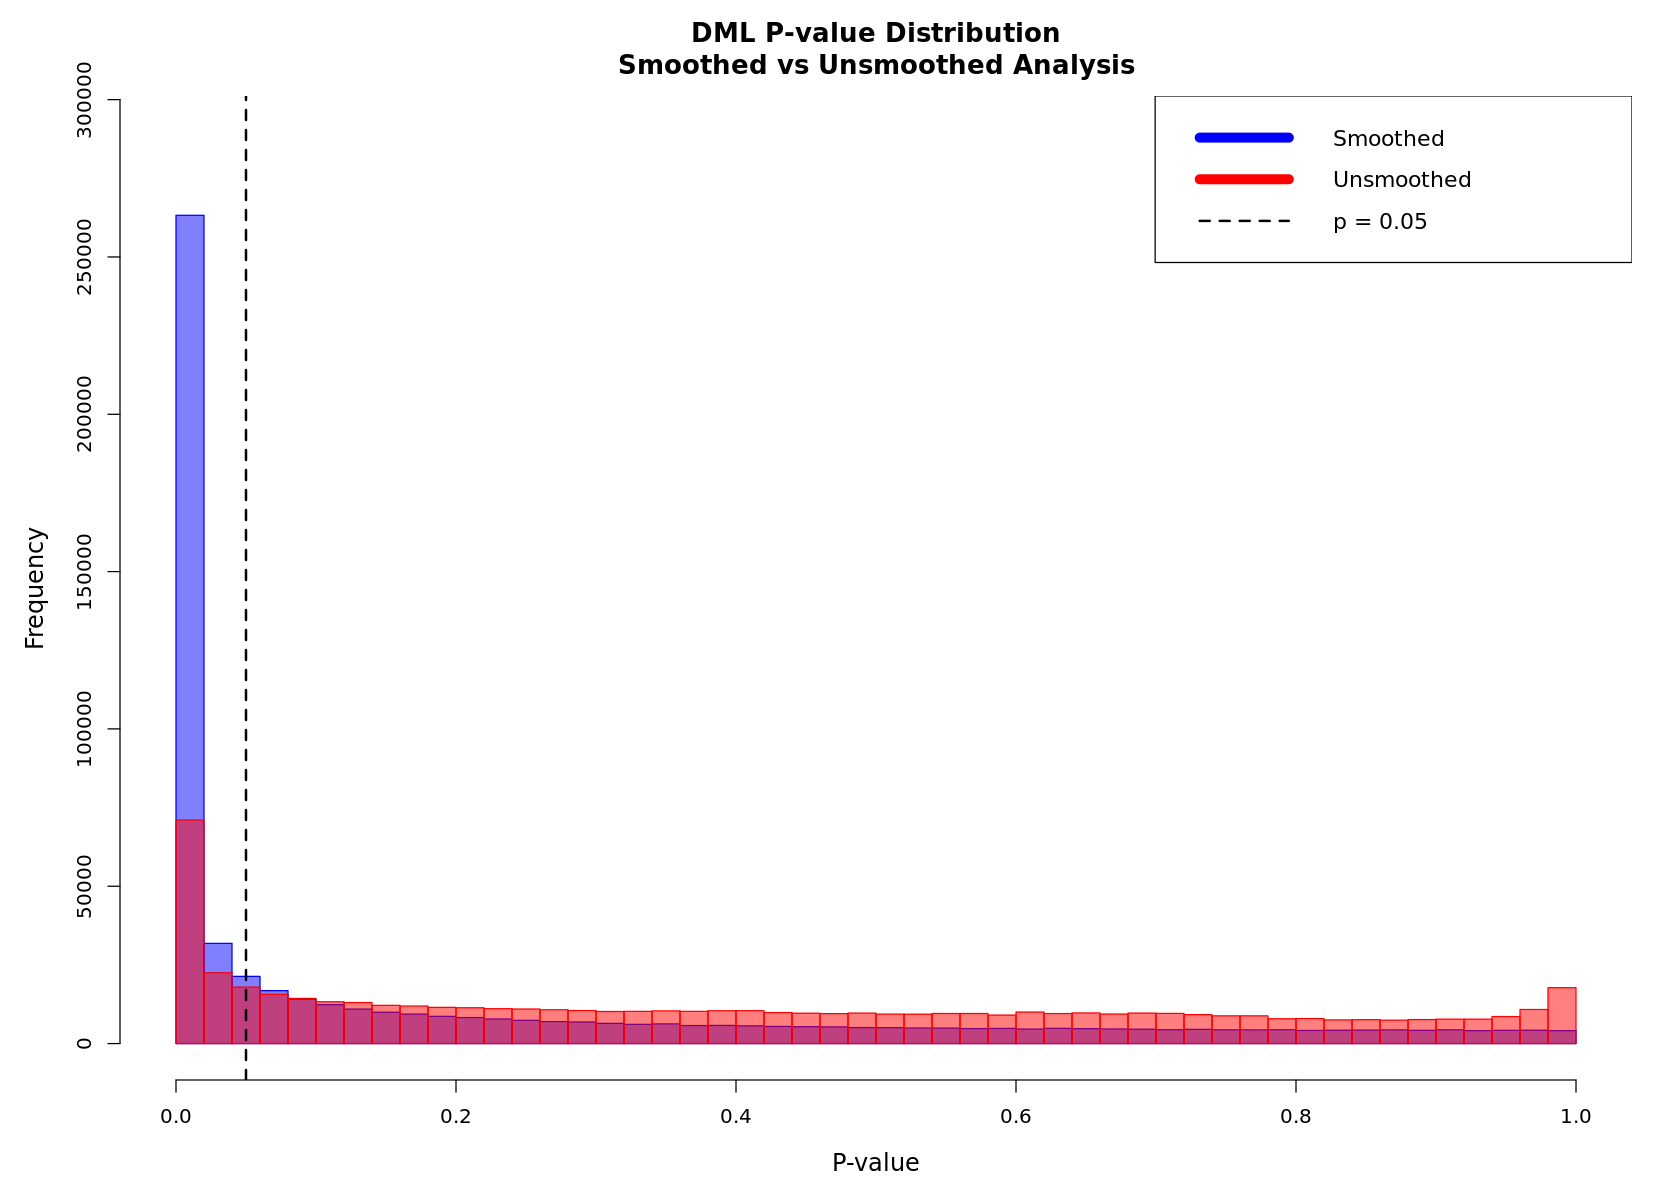

In [85]:
cat("Creating combined axis visualizations...\n")

# Set parameters if not already defined
if(!exists("p_threshold")) p_threshold <- 0.05
if(!exists("delta_threshold")) delta_threshold <- 0.1

# ===== 1. DML P-value Distribution - Overlaid =====
cat("Creating overlaid DML p-value distribution...\n")

#png("DML_pvalue_overlaid.png", width = 1000, height = 700)
par(mar = c(5, 5, 4, 2))

# Create histogram data
hist_smooth <- hist(dmlTest_smoothed$pval, breaks = 50, plot = FALSE)
hist_unsmooth <- hist(dmlTest_unsmoothed$pval, breaks = 50, plot = FALSE)

# Find common y-axis limits
options(repr.plot.width = 14, repr.plot.height = 10)

max_count <- max(c(hist_smooth$counts, hist_unsmooth$counts))

# Plot smoothed first (background)
hist(dmlTest_smoothed$pval, breaks = 50,
     main = "DML P-value Distribution\nSmoothed vs Unsmoothed Analysis",
     xlab = "P-value",
     ylab = "Frequency",
     col = alpha("blue", 0.5),
     border = "blue",
     ylim = c(0, max_count * 1.1),
     cex.main = 1.3,
     cex.lab = 1.2)

# Overlay unsmoothed (foreground)
hist(dmlTest_unsmoothed$pval, breaks = 50,
     col = alpha("red", 0.5),
     border = "red",
     add = TRUE)

# Add significance threshold line
abline(v = p_threshold, col = "black", lty = 2, lwd = 2)

# Add legend
legend("topright", 
       legend = c("Smoothed", "Unsmoothed", paste("p =", p_threshold)),
       col = c("blue", "red", "black"),
       lty = c(1, 1, 2),
       lwd = c(8, 8, 2),
       cex = 1.1)

Creating overlaid DML methylation difference distribution...


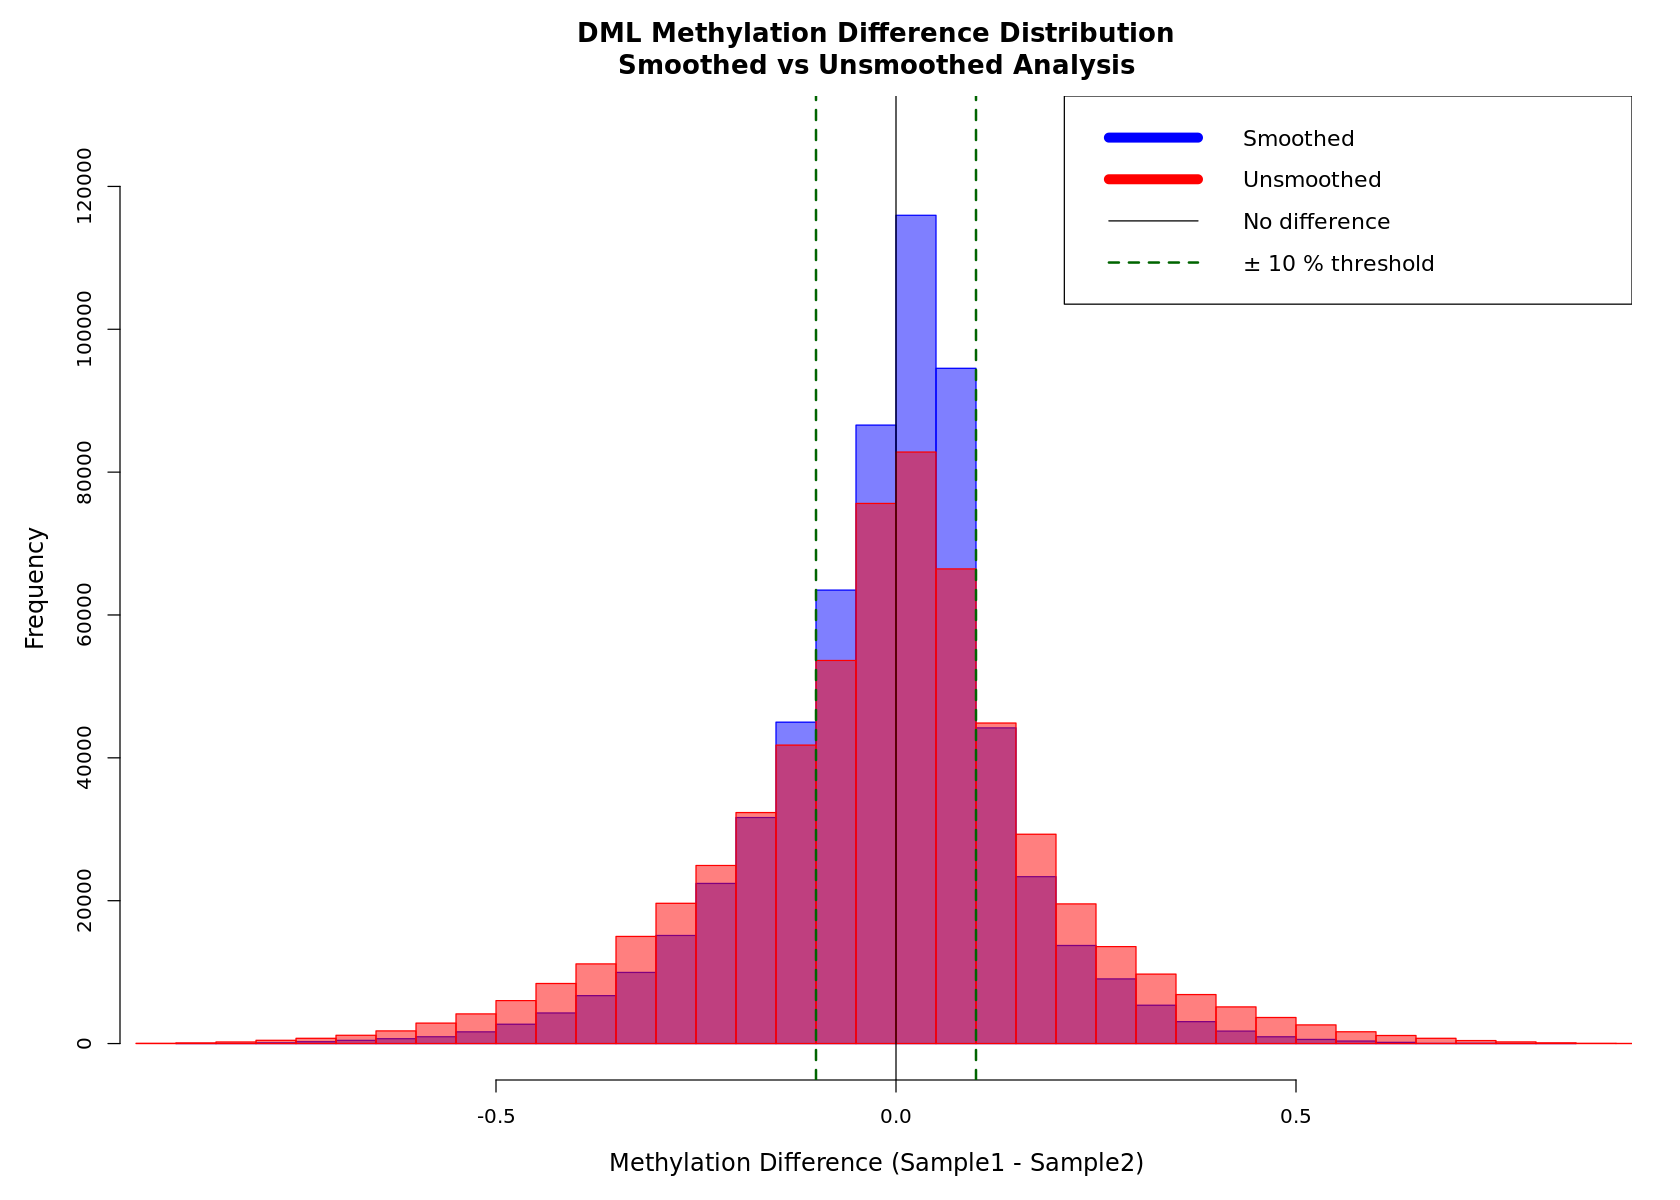

In [86]:
cat("Creating overlaid DML methylation difference distribution...\n")

#png("DML_methylation_diff_overlaid.png", width = 1000, height = 700)
par(mar = c(5, 5, 4, 2))

# Create histogram data for methylation differences
hist_smooth_diff <- hist(dmlTest_smoothed$diff, breaks = 50, plot = FALSE)
hist_unsmooth_diff <- hist(dmlTest_unsmoothed$diff, breaks = 50, plot = FALSE)

# Find common y-axis limits
options(repr.plot.width = 14, repr.plot.height = 10)

max_count_diff <- max(c(hist_smooth_diff$counts, hist_unsmooth_diff$counts))

# Plot smoothed first
hist(dmlTest_smoothed$diff, breaks = 50,
     main = "DML Methylation Difference Distribution\nSmoothed vs Unsmoothed Analysis",
     xlab = "Methylation Difference (Sample1 - Sample2)",
     ylab = "Frequency",
     col = alpha("blue", 0.5),
     border = "blue",
     ylim = c(0, max_count_diff * 1.1),
     cex.main = 1.3,
     cex.lab = 1.2)

# Overlay unsmoothed
hist(dmlTest_unsmoothed$diff, breaks = 50,
     col = alpha("red", 0.5),
     border = "red",
     add = TRUE)

# Add threshold lines
abline(v = 0, col = "black", lty = 1, lwd = 1)
abline(v = c(-delta_threshold, delta_threshold), col = "darkgreen", lty = 2, lwd = 2)

# Add legend
legend("topright", 
       legend = c("Smoothed", "Unsmoothed", "No difference", 
                  paste("±", delta_threshold*100, "% threshold")),
       col = c("blue", "red", "black", "darkgreen"),
       lty = c(1, 1, 1, 2),
       lwd = c(8, 8, 1, 2),
       cex = 1.1)

Creating overlaid volcano plot...


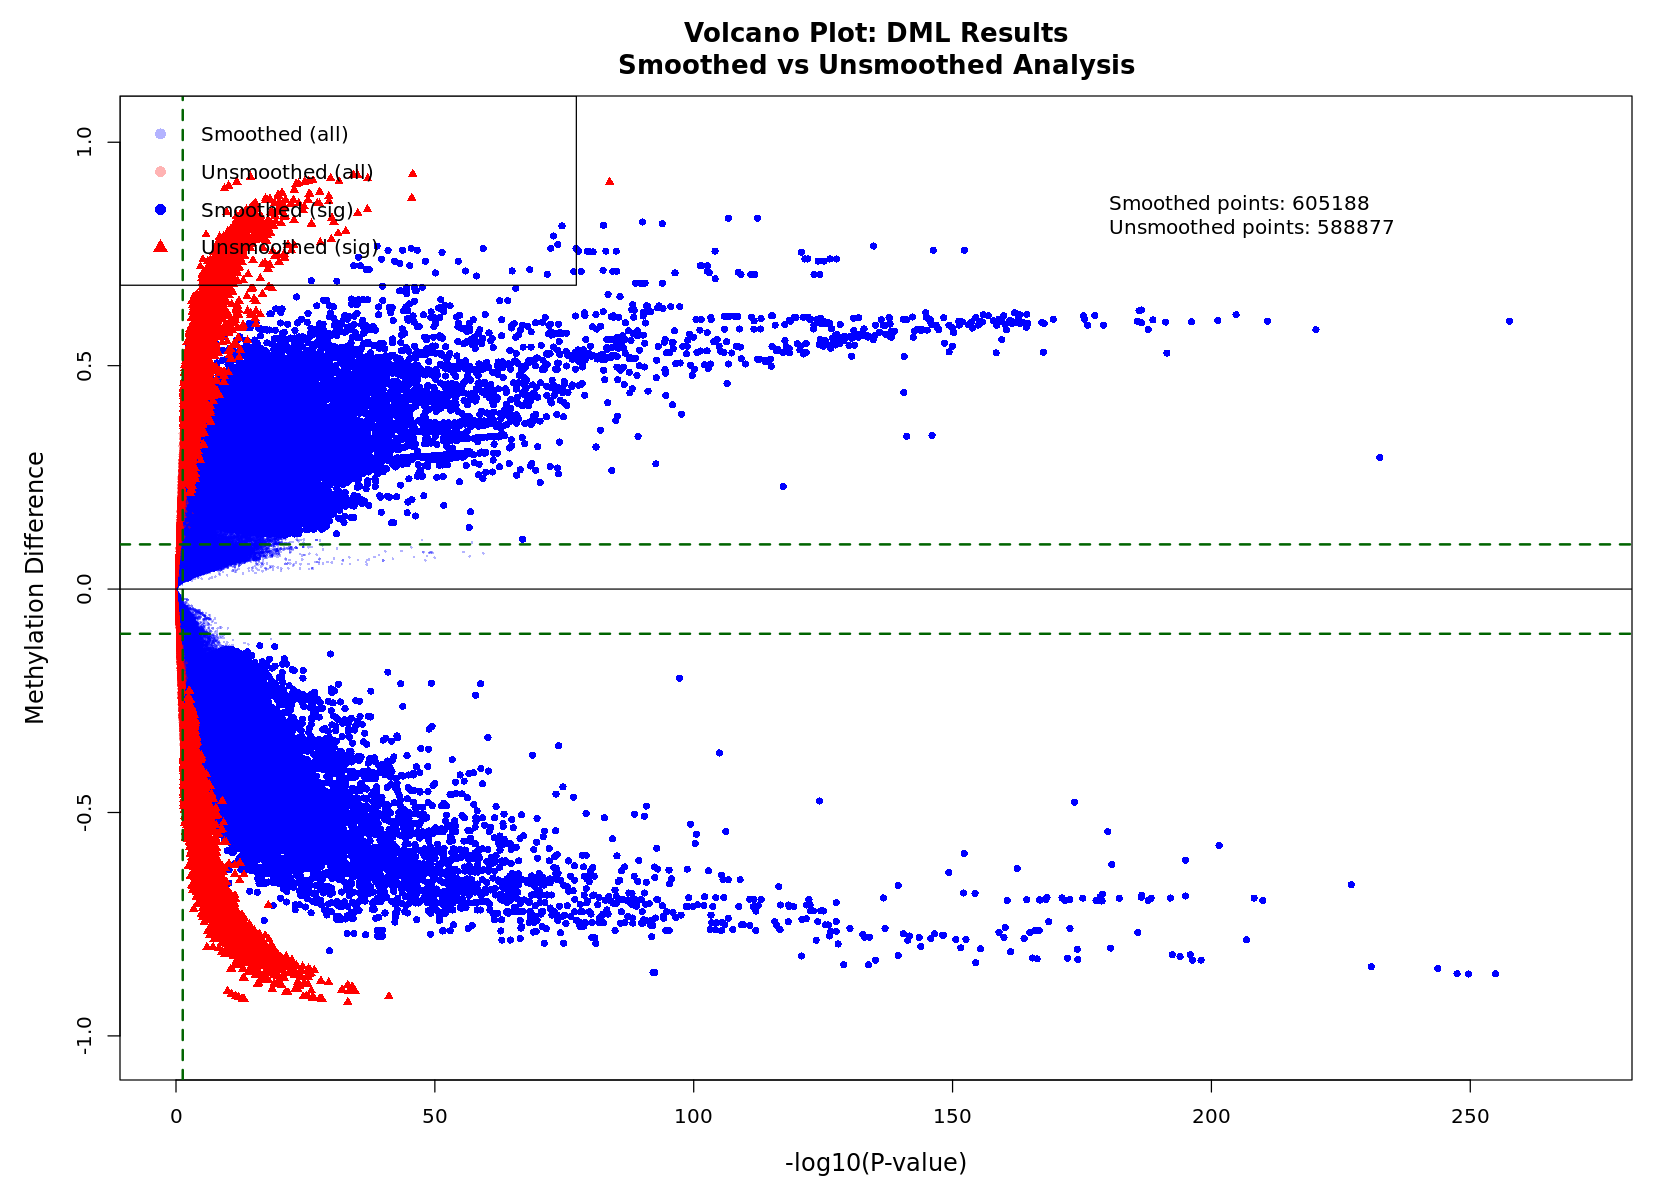

In [87]:
cat("Creating overlaid volcano plot...\n")

#png("volcano_plot_overlaid.png", width = 1000, height = 700)
par(mar = c(5, 5, 4, 2))

options(repr.plot.width = 14, repr.plot.height = 10)

# Clean data for plotting (remove NA, infinite, and zero p-values)
smoothed_clean <- data.frame(
  pval = dmlTest_smoothed$pval,
  diff = dmlTest_smoothed$diff
)
smoothed_clean <- smoothed_clean[!is.na(smoothed_clean$pval) & 
                                smoothed_clean$pval > 0 & 
                                is.finite(smoothed_clean$pval) &
                                !is.na(smoothed_clean$diff) &
                                is.finite(smoothed_clean$diff), ]

unsmoothed_clean <- data.frame(
  pval = dmlTest_unsmoothed$pval,
  diff = dmlTest_unsmoothed$diff
)
unsmoothed_clean <- unsmoothed_clean[!is.na(unsmoothed_clean$pval) & 
                                    unsmoothed_clean$pval > 0 & 
                                    is.finite(unsmoothed_clean$pval) &
                                    !is.na(unsmoothed_clean$diff) &
                                    is.finite(unsmoothed_clean$diff), ]

# Calculate plot limits with cleaned data
if(nrow(smoothed_clean) > 0 && nrow(unsmoothed_clean) > 0) {
  x_max <- max(c(-log10(smoothed_clean$pval), -log10(unsmoothed_clean$pval)), na.rm = TRUE)
  y_max <- max(c(abs(smoothed_clean$diff), abs(unsmoothed_clean$diff)), na.rm = TRUE)
  y_min <- min(c(smoothed_clean$diff, unsmoothed_clean$diff), na.rm = TRUE)
  
  # Handle edge cases
  if(!is.finite(x_max) || x_max <= 0) x_max <- 10
  if(!is.finite(y_max) || y_max <= 0) y_max <- 1
  if(!is.finite(y_min)) y_min <- -1
  
} else {
  cat("Warning: No valid data for volcano plot. Skipping...\n")
} 

  # Plot background points (all data)
  plot(-log10(smoothed_clean$pval), smoothed_clean$diff,
       xlim = c(0, x_max * 1.05),
       ylim = c(y_min * 1.1, y_max * 1.1),
       xlab = "-log10(P-value)",
       ylab = "Methylation Difference",
       main = "Volcano Plot: DML Results\nSmoothed vs Unsmoothed Analysis",
       pch = 16, cex = 0.3, col = alpha("blue", 0.3),
       cex.main = 1.3,
       cex.lab = 1.2)
  
  # Overlay unsmoothed background points
  points(-log10(unsmoothed_clean$pval), unsmoothed_clean$diff,
         pch = 16, cex = 0.3, col = alpha("red", 0.3))
  
  # Highlight significant points if they exist
  if(exists("dmls_smoothed") && nrow(dmls_smoothed) > 0) {
    # Create position identifier for matching
    smoothed_positions <- paste(dmlTest_smoothed$chr, dmlTest_smoothed$pos, sep = "_")
    dmls_smoothed_positions <- paste(dmls_smoothed$chr, dmls_smoothed$pos, sep = "_")
    
    # Find indices of significant DMLs in the full dataset
    sig_smooth_idx <- which(smoothed_positions %in% dmls_smoothed_positions &
                           !is.na(dmlTest_smoothed$pval) & 
                           dmlTest_smoothed$pval > 0 &
                           is.finite(dmlTest_smoothed$pval) &
                           !is.na(dmlTest_smoothed$diff) &
                           is.finite(dmlTest_smoothed$diff))
    
    if(length(sig_smooth_idx) > 0) {
      points(-log10(dmlTest_smoothed$pval[sig_smooth_idx]), 
             dmlTest_smoothed$diff[sig_smooth_idx],
             pch = 16, cex = 0.8, col = "blue")
    }
  }
  
  if(exists("dmls_unsmoothed") && nrow(dmls_unsmoothed) > 0) {
    # Create position identifier for matching
    unsmoothed_positions <- paste(dmlTest_unsmoothed$chr, dmlTest_unsmoothed$pos, sep = "_")
    dmls_unsmoothed_positions <- paste(dmls_unsmoothed$chr, dmls_unsmoothed$pos, sep = "_")
    
    # Find indices of significant DMLs in the full dataset
    sig_unsmooth_idx <- which(unsmoothed_positions %in% dmls_unsmoothed_positions &
                             !is.na(dmlTest_unsmoothed$pval) & 
                             dmlTest_unsmoothed$pval > 0 &
                             is.finite(dmlTest_unsmoothed$pval) &
                             !is.na(dmlTest_unsmoothed$diff) &
                             is.finite(dmlTest_unsmoothed$diff))
    
    if(length(sig_unsmooth_idx) > 0) {
      points(-log10(dmlTest_unsmoothed$pval[sig_unsmooth_idx]), 
             dmlTest_unsmoothed$diff[sig_unsmooth_idx],
             pch = 17, cex = 0.8, col = "red")  # Different shape for distinction
    }
  }
  
  # Add threshold lines
  if(is.finite(-log10(p_threshold))) {
    abline(v = -log10(p_threshold), col = "darkgreen", lty = 2, lwd = 2)
  }
  abline(h = c(-delta_threshold, delta_threshold), col = "darkgreen", lty = 2, lwd = 2)
  abline(h = 0, col = "black", lty = 1, lwd = 1)
  
  # Add legend
  legend_items <- c("Smoothed (all)", "Unsmoothed (all)")
  legend_colors <- c(alpha("blue", 0.3), alpha("red", 0.3))
  legend_pch <- c(16, 16)
  
  if(exists("dmls_smoothed") && nrow(dmls_smoothed) > 0) {
    legend_items <- c(legend_items, "Smoothed (sig)")
    legend_colors <- c(legend_colors, "blue")
    legend_pch <- c(legend_pch, 16)
  }
  
  if(exists("dmls_unsmoothed") && nrow(dmls_unsmoothed) > 0) {
    legend_items <- c(legend_items, "Unsmoothed (sig)")
    legend_colors <- c(legend_colors, "red")
    legend_pch <- c(legend_pch, 17)
  }
  
  legend("topleft", 
         legend = legend_items,
         col = legend_colors,
         pch = legend_pch,
         cex = 1.0,
         pt.cex = 1.2)
  
  # Add data summary text
  text(x = x_max * 0.7, y = y_max * 0.9,
       labels = paste("Smoothed points:", nrow(smoothed_clean),
                     "\nUnsmoothed points:", nrow(unsmoothed_clean)),
       cex = 1.0, adj = 0)


Creating overlaid DMR length distribution...


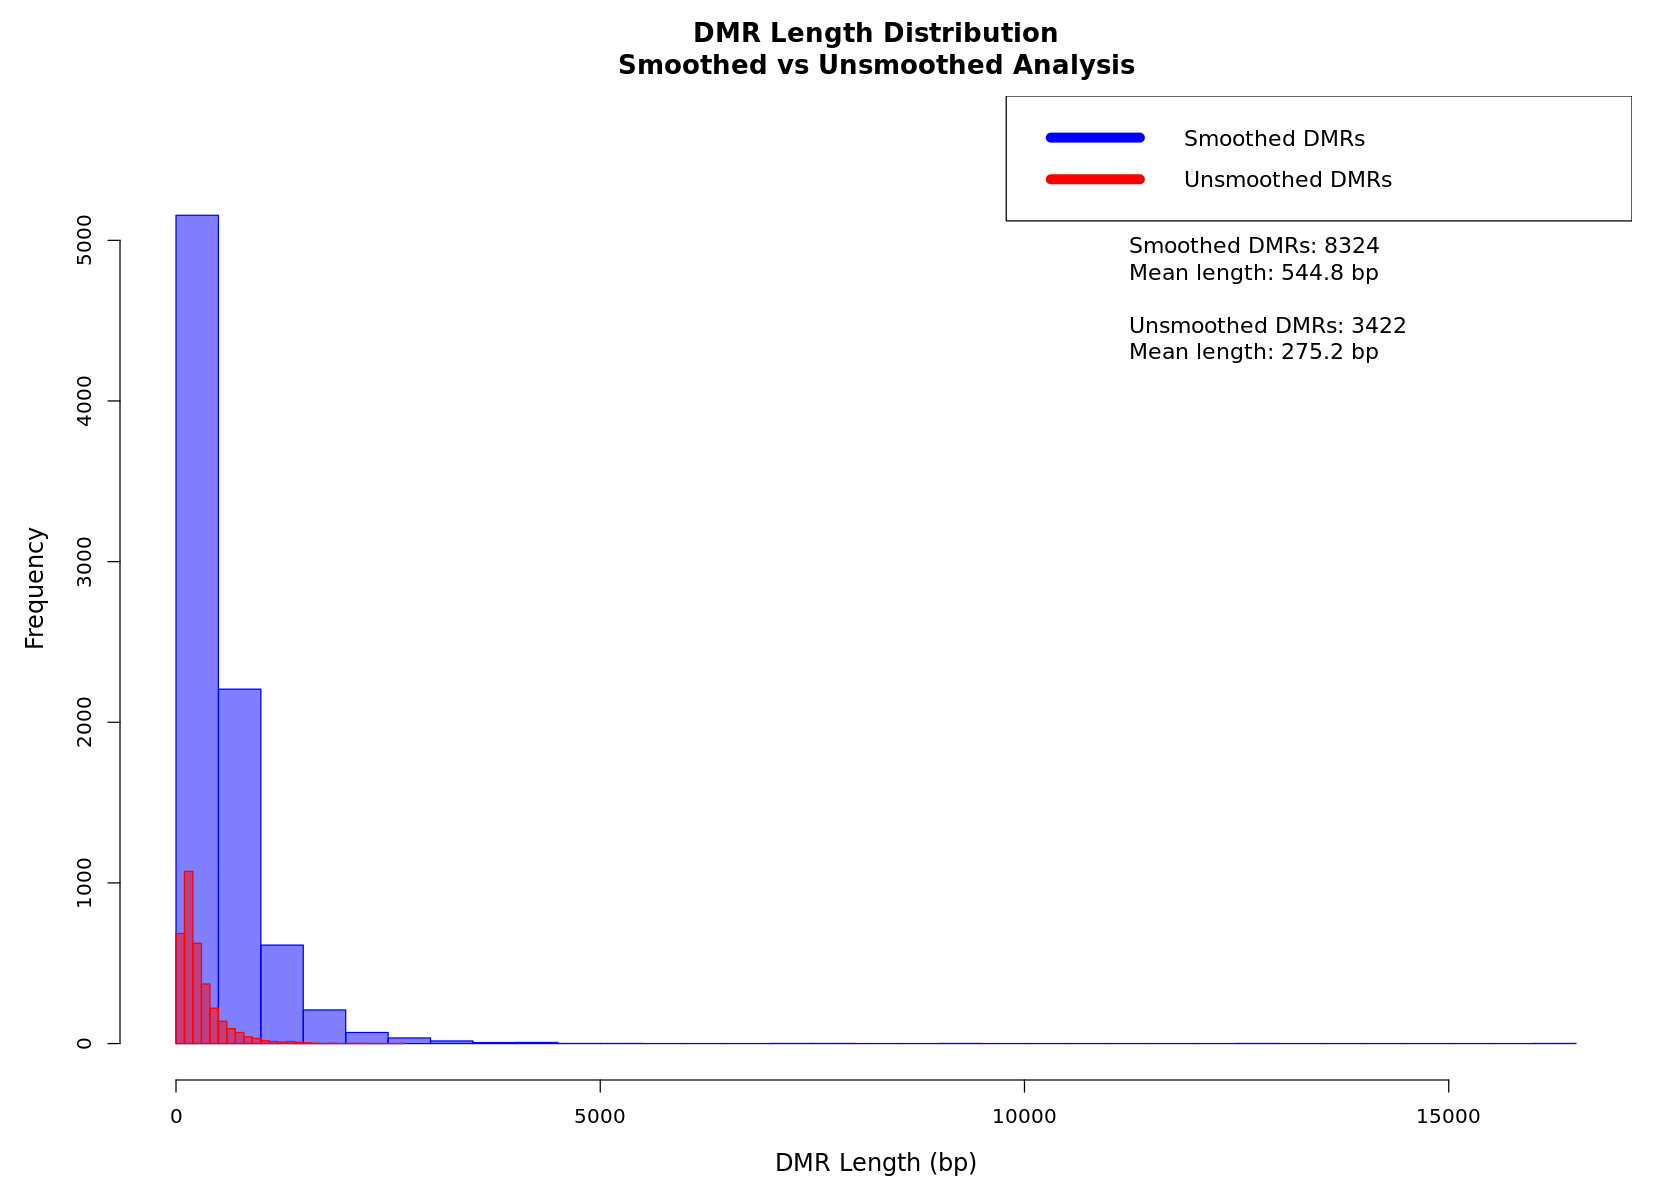

In [88]:
 cat("Creating overlaid DMR length distribution...\n")
  
 # png("DMR_length_overlaid.png", width = 1000, height = 700)
  par(mar = c(5, 5, 4, 2))
  
  # Create histogram data for DMR lengths
  options(repr.plot.width = 14, repr.plot.height = 10)

  hist_smooth_dmr <- hist(dmrs_smoothed$length, breaks = 30, plot = FALSE)
  hist_unsmooth_dmr <- hist(dmrs_unsmoothed$length, breaks = 30, plot = FALSE)
  
  # Find common y-axis limits
  max_count_dmr <- max(c(hist_smooth_dmr$counts, hist_unsmooth_dmr$counts))
  
  # Plot smoothed DMR lengths
  hist(dmrs_smoothed$length, breaks = 30,
       main = "DMR Length Distribution\nSmoothed vs Unsmoothed Analysis",
       xlab = "DMR Length (bp)",
       ylab = "Frequency",
       col = alpha("blue", 0.5),
       border = "blue",
       ylim = c(0, max_count_dmr * 1.1),
       cex.main = 1.3,
       cex.lab = 1.2)
  
  # Overlay unsmoothed DMR lengths
  hist(dmrs_unsmoothed$length, breaks = 30,
       col = alpha("red", 0.5),
       border = "red",
       add = TRUE)
  
  # Add statistics text
  text(x = max(c(dmrs_smoothed$length, dmrs_unsmoothed$length)) * 0.7,
       y = max_count_dmr * 0.9,
       labels = paste("Smoothed DMRs:", nrow(dmrs_smoothed), 
                     "\nMean length:", round(mean(dmrs_smoothed$length), 1), "bp",
                     "\n\nUnsmoothed DMRs:", nrow(dmrs_unsmoothed),
                     "\nMean length:", round(mean(dmrs_unsmoothed$length), 1), "bp"),
       cex = 1.1,
       adj = 0)
  
  # Add legend
  legend("topright", 
         legend = c("Smoothed DMRs", "Unsmoothed DMRs"),
         col = c("blue", "red"),
         lwd = 8,
         cex = 1.1)
  

Creating overlaid DMR methylation difference distribution...


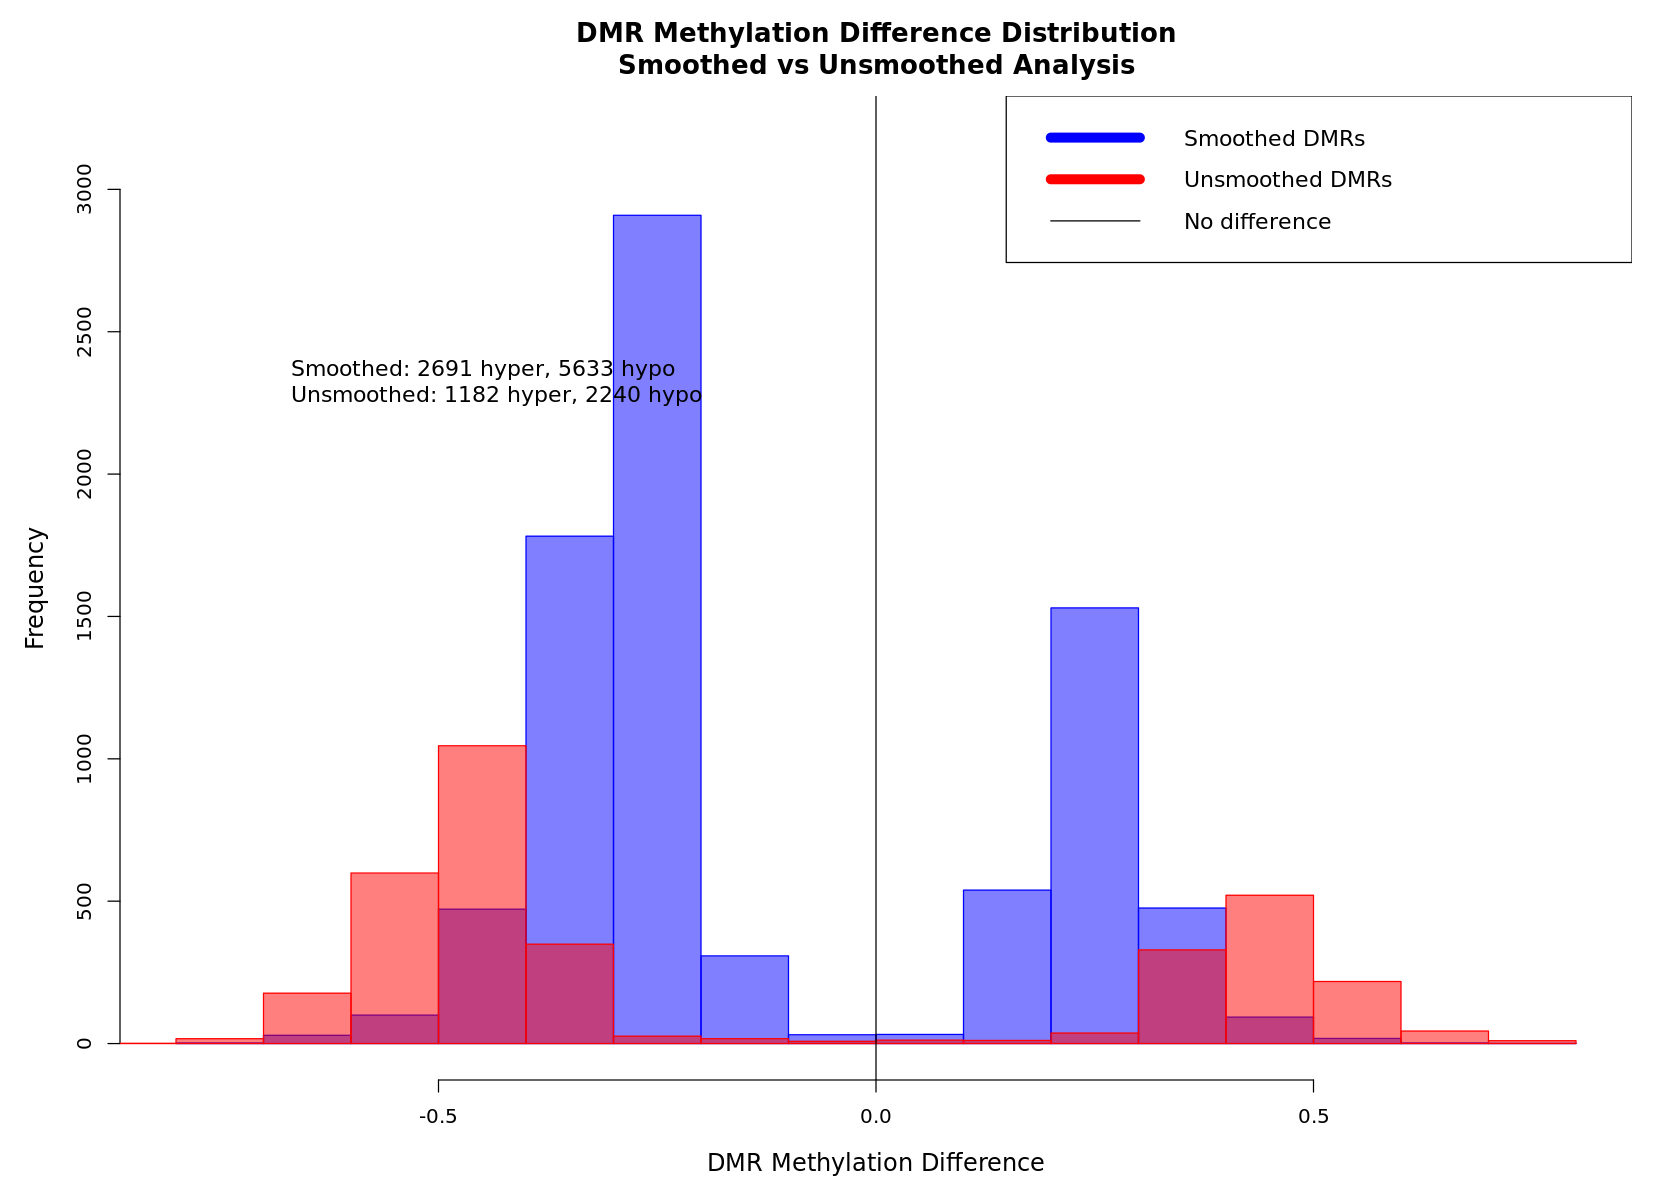

In [89]:
cat("Creating overlaid DMR methylation difference distribution...\n")
  
  #png("DMR_methylation_diff_overlaid.png", width = 1000, height = 700)
  par(mar = c(5, 5, 4, 2))
  
  # Create histogram data for DMR methylation differences
  hist_smooth_dmr_diff <- hist(dmrs_smoothed$diff.Methy, breaks = 20, plot = FALSE)
  hist_unsmooth_dmr_diff <- hist(dmrs_unsmoothed$diff.Methy, breaks = 20, plot = FALSE)
  
  # Find common y-axis limits
  options(repr.plot.width = 14, repr.plot.height = 10)

  max_count_dmr_diff <- max(c(hist_smooth_dmr_diff$counts, hist_unsmooth_dmr_diff$counts))
  
  # Plot smoothed DMR methylation differences
  hist(dmrs_smoothed$diff.Methy, breaks = 20,
       main = "DMR Methylation Difference Distribution\nSmoothed vs Unsmoothed Analysis",
       xlab = "DMR Methylation Difference",
       ylab = "Frequency",
       col = alpha("blue", 0.5),
       border = "blue",
       ylim = c(0, max_count_dmr_diff * 1.1),
       cex.main = 1.3,
       cex.lab = 1.2)
  
  # Overlay unsmoothed DMR methylation differences
  hist(dmrs_unsmoothed$diff.Methy, breaks = 20,
       col = alpha("red", 0.5),
       border = "red",
       add = TRUE)
  
  # Add reference line at zero
  abline(v = 0, col = "black", lty = 1, lwd = 1)
  
  # Count hyper/hypo DMRs
  hyper_smooth <- sum(dmrs_smoothed$diff.Methy > 0)
  hypo_smooth <- sum(dmrs_smoothed$diff.Methy < 0)
  hyper_unsmooth <- sum(dmrs_unsmoothed$diff.Methy > 0)
  hypo_unsmooth <- sum(dmrs_unsmoothed$diff.Methy < 0)
  
  # Add statistics text
  text(x = min(c(dmrs_smoothed$diff.Methy, dmrs_unsmoothed$diff.Methy)) * 0.8,
       y = max_count_dmr_diff * 0.8,
       labels = paste("Smoothed:", hyper_smooth, "hyper,", hypo_smooth, "hypo",
                     "\nUnsmoothed:", hyper_unsmooth, "hyper,", hypo_unsmooth, "hypo"),
       cex = 1.1,
       adj = 0)
  
  # Add legend
  legend("topright", 
         legend = c("Smoothed DMRs", "Unsmoothed DMRs", "No difference"),
         col = c("blue", "red", "black"),
         lty = c(1, 1, 1),
         lwd = c(8, 8, 1),
         cex = 1.1)

In [118]:
create_granges <- function(df, score_column, name_prefix = "") {
  if(nrow(df) == 0) {
    return(GRanges())
  }
  
  gr <- GRanges(
    seqnames = df$chr,
    ranges = IRanges(start = df$pos, end = df$pos),
    score = df[[score_column]],
    name = paste0(name_prefix, "_", 1:nrow(df))
  )
  
  # Get chromosomes present in the data
  data_chrs <- unique(as.character(seqnames(gr)))
  
  # Get chromosomes that exist in reference genome
  ref_chrs <- seqnames(seqinfo_genome)
  available_chrs <- data_chrs[data_chrs %in% ref_chrs]
  
  # Start with available chromosomes from reference
  if(length(available_chrs) > 0) {
    available_seqinfo <- seqinfo_genome[available_chrs]
  } else {
    available_seqinfo <- Seqinfo()
  }
  
  # Handle chromosomes not in reference genome
  missing_chrs <- data_chrs[!data_chrs %in% ref_chrs]
  if(length(missing_chrs) > 0) {
    cat("Warning: Chromosomes not found in reference genome:", paste(missing_chrs, collapse = ", "), "\n")
    cat("These will be assigned maximum chromosome length.\n")
    
    # Create seqinfo for missing chromosomes
    max_length <- max(seqlengths(seqinfo_genome), na.rm = TRUE)
    missing_seqinfo <- Seqinfo(seqnames = missing_chrs,
                              seqlengths = rep(max_length, length(missing_chrs)),
                              genome = genome_build)
    
    # Combine seqinfos
    if(length(available_seqinfo) > 0) {
      available_seqinfo <- merge(available_seqinfo, missing_seqinfo)
    } else {
      available_seqinfo <- missing_seqinfo
    }
  }
  
  # Assign seqinfo to GRanges
  seqinfo(gr) <- available_seqinfo
  
  return(gr)
}




In [119]:
create_dmr_granges <- function(dmr_df, score_column, name_prefix = "") {
  if(nrow(dmr_df) == 0) {
    return(GRanges())
  }
  
  gr <- GRanges(
    seqnames = dmr_df$chr,
    ranges = IRanges(start = dmr_df$start, end = dmr_df$end),
    score = dmr_df[[score_column]],
    name = paste0(name_prefix, "_", 1:nrow(dmr_df)),
    length = dmr_df$end - dmr_df$start + 1,
    nCG = dmr_df$nCG
  )
  
  # Get chromosomes present in the data
  data_chrs <- unique(as.character(seqnames(gr)))
  
  # Get chromosomes that exist in reference genome
  ref_chrs <- seqnames(seqinfo_genome)
  available_chrs <- data_chrs[data_chrs %in% ref_chrs]
  
  # Start with available chromosomes from reference
  if(length(available_chrs) > 0) {
    available_seqinfo <- seqinfo_genome[available_chrs]
  } else {
    available_seqinfo <- Seqinfo()
  }
  
  # Handle chromosomes not in reference genome
  missing_chrs <- data_chrs[!data_chrs %in% ref_chrs]
  if(length(missing_chrs) > 0) {
    cat("Warning: DMR chromosomes not found in reference genome:", paste(missing_chrs, collapse = ", "), "\n")
    
    # Create seqinfo for missing chromosomes
    max_length <- max(seqlengths(seqinfo_genome), na.rm = TRUE)
    missing_seqinfo <- Seqinfo(seqnames = missing_chrs,
                              seqlengths = rep(max_length, length(missing_chrs)),
                              genome = genome_build)
    
    # Combine seqinfos
    if(length(available_seqinfo) > 0) {
      available_seqinfo <- merge(available_seqinfo, missing_seqinfo)
    } else {
      available_seqinfo <- missing_seqinfo
    }
  }
  
  # Assign seqinfo to GRanges
  seqinfo(gr) <- available_seqinfo
  
  return(gr)
}

In [120]:
# ===== 1. Methylation Difference Tracks =====
cat("\n=== Creating Methylation Difference Tracks ===\n")

# Smoothed methylation differences
if(exists("dmlTest_smoothed") && nrow(dmlTest_smoothed) > 0) {
  smoothed_diff_gr <- create_granges(dmlTest_smoothed, "diff", "smoothed_diff")
  export.bw(smoothed_diff_gr, "methylation_difference_smoothed.bw")
  cat("Created: methylation_difference_smoothed.bw\n")
}

# Unsmoothed methylation differences
if(exists("dmlTest_unsmoothed") && nrow(dmlTest_unsmoothed) > 0) {
  unsmoothed_diff_gr <- create_granges(dmlTest_unsmoothed, "diff", "unsmoothed_diff")
  export.bw(unsmoothed_diff_gr, "methylation_difference_unsmoothed.bw")
  cat("Created: methylation_difference_unsmoothed.bw\n")
}


=== Creating Methylation Difference Tracks ===
Created: methylation_difference_smoothed.bw
Created: methylation_difference_unsmoothed.bw


In [121]:
# ===== 2. Statistical Significance Tracks (-log10 p-values) =====
cat("\n=== Creating Statistical Significance Tracks ===\n")

# Smoothed -log10 p-values
if(exists("dmlTest_smoothed") && nrow(dmlTest_smoothed) > 0) {
  # Handle zero and very small p-values
  smoothed_pval_clean <- dmlTest_smoothed
  smoothed_pval_clean$log10_pval <- ifelse(
    smoothed_pval_clean$pval > 0 & is.finite(smoothed_pval_clean$pval),
    -log10(smoothed_pval_clean$pval),
    -log10(1e-300)  # Cap very small p-values
  )
  
  smoothed_pval_gr <- create_granges(smoothed_pval_clean, "log10_pval", "smoothed_pval")
  export.bw(smoothed_pval_gr, "significance_smoothed.bw")
  cat("Created: significance_smoothed.bw\n")
}

# Unsmoothed -log10 p-values
if(exists("dmlTest_unsmoothed") && nrow(dmlTest_unsmoothed) > 0) {
  unsmoothed_pval_clean <- dmlTest_unsmoothed
  unsmoothed_pval_clean$log10_pval <- ifelse(
    unsmoothed_pval_clean$pval > 0 & is.finite(unsmoothed_pval_clean$pval),
    -log10(unsmoothed_pval_clean$pval),
    -log10(1e-300)
  )
  
  unsmoothed_pval_gr <- create_granges(unsmoothed_pval_clean, "log10_pval", "unsmoothed_pval")
  export.bw(unsmoothed_pval_gr, "significance_unsmoothed.bw")
  cat("Created: significance_unsmoothed.bw\n")
}


=== Creating Statistical Significance Tracks ===
Created: significance_smoothed.bw
Created: significance_unsmoothed.bw


In [122]:
# ===== 3. Significant DML Tracks (Binary and Weighted) =====
cat("\n=== Creating Significant DML Tracks ===\n")

# Smoothed significant DMLs - Binary track (1 for significant, 0 for not)
if(exists("dmls_smoothed") && nrow(dmls_smoothed) > 0) {
  dmls_smoothed_binary <- dmls_smoothed
  dmls_smoothed_binary$binary_score <- 1
  
  dmls_smoothed_binary_gr <- create_granges(dmls_smoothed_binary, "binary_score", "smoothed_sig_binary")
  export.bw(dmls_smoothed_binary_gr, "significant_DMLs_smoothed_binary.bw")
  cat("Created: significant_DMLs_smoothed_binary.bw\n")
  
  # Weighted by methylation difference
  dmls_smoothed_weighted_gr <- create_granges(dmls_smoothed, "diff", "smoothed_sig_weighted")
  export.bw(dmls_smoothed_weighted_gr, "significant_DMLs_smoothed_weighted.bw")
  cat("Created: significant_DMLs_smoothed_weighted.bw\n")
}

# Unsmoothed significant DMLs
if(exists("dmls_unsmoothed") && nrow(dmls_unsmoothed) > 0) {
  dmls_unsmoothed_binary <- dmls_unsmoothed
  dmls_unsmoothed_binary$binary_score <- 1
  
  dmls_unsmoothed_binary_gr <- create_granges(dmls_unsmoothed_binary, "binary_score", "unsmoothed_sig_binary")
  export.bw(dmls_unsmoothed_binary_gr, "significant_DMLs_unsmoothed_binary.bw")
  cat("Created: significant_DMLs_unsmoothed_binary.bw\n")
  
  # Weighted by methylation difference
  dmls_unsmoothed_weighted_gr <- create_granges(dmls_unsmoothed, "diff", "unsmoothed_sig_weighted")
  export.bw(dmls_unsmoothed_weighted_gr, "significant_DMLs_unsmoothed_weighted.bw")
  cat("Created: significant_DMLs_unsmoothed_weighted.bw\n")
}



=== Creating Significant DML Tracks ===
Created: significant_DMLs_smoothed_binary.bw
Created: significant_DMLs_smoothed_weighted.bw
Created: significant_DMLs_unsmoothed_binary.bw
Created: significant_DMLs_unsmoothed_weighted.bw


In [127]:
cat("\n=== Creating DMR Tracks ===\n")

# Smoothed DMRs - Multiple scoring schemes
if(exists("dmrs_smoothed") && nrow(dmrs_smoothed) > 0) {
  # DMR track weighted by methylation difference
  dmrs_smoothed_diff_gr <- create_dmr_granges(dmrs_smoothed, "diff.Methy", "smoothed_dmr_diff")
  export.bw(dmrs_smoothed_diff_gr, "DMRs_smoothed_methylation_difference.bw")
  cat("Created: DMRs_smoothed_methylation_difference.bw\n")
  
  # DMR track weighted by area statistic (DSS significance measure)
  cat("Processing smoothed DMR significance track using areaStat...\n")
  dmrs_smoothed_sig <- dmrs_smoothed
  
  if("areaStat" %in% colnames(dmrs_smoothed_sig)) {
    # Use areaStat directly (higher values = more significant)
    dmrs_smoothed_sig_gr <- create_dmr_granges(dmrs_smoothed_sig, "areaStat", "smoothed_dmr_sig")
    export.bw(dmrs_smoothed_sig_gr, "DMRs_smoothed_significance.bw")
    cat("Created: DMRs_smoothed_significance.bw (using areaStat)\n")
  } else {
    cat("Warning: No 'areaStat' column found in DMR data. Available columns:\n")
    print(colnames(dmrs_smoothed_sig))
  }
  
  # DMR track weighted by number of CpGs
  dmrs_smoothed_cpg_gr <- create_dmr_granges(dmrs_smoothed, "nCG", "smoothed_dmr_cpg")
  export.bw(dmrs_smoothed_cpg_gr, "DMRs_smoothed_CpG_count.bw")
  cat("Created: DMRs_smoothed_CpG_count.bw\n")
}

# Unsmoothed DMRs
if(exists("dmrs_unsmoothed") && nrow(dmrs_unsmoothed) > 0) {
  # DMR track weighted by methylation difference
  dmrs_unsmoothed_diff_gr <- create_dmr_granges(dmrs_unsmoothed, "diff.Methy", "unsmoothed_dmr_diff")
  export.bw(dmrs_unsmoothed_diff_gr, "DMRs_unsmoothed_methylation_difference.bw")
  cat("Created: DMRs_unsmoothed_methylation_difference.bw\n")
  
  # DMR track weighted by area statistic (DSS significance measure)
  cat("Processing unsmoothed DMR significance track using areaStat...\n")
  dmrs_unsmoothed_sig <- dmrs_unsmoothed
  
  if("areaStat" %in% colnames(dmrs_unsmoothed_sig)) {
    # Use areaStat directly (higher values = more significant)
    dmrs_unsmoothed_sig_gr <- create_dmr_granges(dmrs_unsmoothed_sig, "areaStat", "unsmoothed_dmr_sig")
    export.bw(dmrs_unsmoothed_sig_gr, "DMRs_unsmoothed_significance.bw")
    cat("Created: DMRs_unsmoothed_significance.bw (using areaStat)\n")
  } else {
    cat("Warning: No 'areaStat' column found in unsmoothed DMR data. Available columns:\n")
    print(colnames(dmrs_unsmoothed_sig))
  }
  
  # DMR track weighted by number of CpGs
  dmrs_unsmoothed_cpg_gr <- create_dmr_granges(dmrs_unsmoothed, "nCG", "unsmoothed_dmr_cpg")
  export.bw(dmrs_unsmoothed_cpg_gr, "DMRs_unsmoothed_CpG_count.bw")
  cat("Created: DMRs_unsmoothed_CpG_count.bw\n")
}


=== Creating DMR Tracks ===
Created: DMRs_smoothed_methylation_difference.bw
Processing smoothed DMR significance track using areaStat...
Created: DMRs_smoothed_significance.bw (using areaStat)
Created: DMRs_smoothed_CpG_count.bw
Created: DMRs_unsmoothed_methylation_difference.bw
Processing unsmoothed DMR significance track using areaStat...
Created: DMRs_unsmoothed_significance.bw (using areaStat)
Created: DMRs_unsmoothed_CpG_count.bw


In [124]:
cat("\n=== Creating Comparison Tracks ===\n")

# Method agreement track (where both methods find significant DMLs)
if(exists("dmls_smoothed") && exists("dmls_unsmoothed") && 
   nrow(dmls_smoothed) > 0 && nrow(dmls_unsmoothed) > 0) {
  
  # Find overlapping positions
  smoothed_positions <- paste(dmls_smoothed$chr, dmls_smoothed$pos, sep = "_")
  unsmoothed_positions <- paste(dmls_unsmoothed$chr, dmls_unsmoothed$pos, sep = "_")
  overlapping_positions <- intersect(smoothed_positions, unsmoothed_positions)
  
  if(length(overlapping_positions) > 0) {
    # Create consensus track
    consensus_dmls <- dmls_smoothed[paste(dmls_smoothed$chr, dmls_smoothed$pos, sep = "_") %in% overlapping_positions, ]
    consensus_dmls$consensus_score <- 1
    
    consensus_gr <- create_granges(consensus_dmls, "consensus_score", "consensus")
    export.bw(consensus_gr, "DMLs_consensus_both_methods.bw")
    cat("Created: DMLs_consensus_both_methods.bw\n")
    
    # Weighted consensus by average methylation difference
    consensus_weighted <- consensus_dmls
    unsmoothed_subset <- dmls_unsmoothed[paste(dmls_unsmoothed$chr, dmls_unsmoothed$pos, sep = "_") %in% overlapping_positions, ]
    
    # Match order for averaging
    match_idx <- match(paste(consensus_weighted$chr, consensus_weighted$pos, sep = "_"),
                      paste(unsmoothed_subset$chr, unsmoothed_subset$pos, sep = "_"))
    consensus_weighted$avg_diff <- (consensus_weighted$diff + unsmoothed_subset$diff[match_idx]) / 2
    
    consensus_weighted_gr <- create_granges(consensus_weighted, "avg_diff", "consensus_weighted")
    export.bw(consensus_weighted_gr, "DMLs_consensus_weighted_average.bw")
    cat("Created: DMLs_consensus_weighted_average.bw\n")
  }
}

# Method-specific tracks (unique to each method)
if(exists("dmls_smoothed") && exists("dmls_unsmoothed") && 
   nrow(dmls_smoothed) > 0 && nrow(dmls_unsmoothed) > 0) {
  
  smoothed_positions <- paste(dmls_smoothed$chr, dmls_smoothed$pos, sep = "_")
  unsmoothed_positions <- paste(dmls_unsmoothed$chr, dmls_unsmoothed$pos, sep = "_")
  
  # Smoothed-specific DMLs
  smoothed_specific <- dmls_smoothed[!smoothed_positions %in% unsmoothed_positions, ]
  if(nrow(smoothed_specific) > 0) {
    smoothed_specific_gr <- create_granges(smoothed_specific, "diff", "smoothed_specific")
    export.bw(smoothed_specific_gr, "DMLs_smoothed_specific.bw")
    cat("Created: DMLs_smoothed_specific.bw\n")
  }
  
  # Unsmoothed-specific DMLs
  unsmoothed_specific <- dmls_unsmoothed[!unsmoothed_positions %in% smoothed_positions, ]
  if(nrow(unsmoothed_specific) > 0) {
    unsmoothed_specific_gr <- create_granges(unsmoothed_specific, "diff", "unsmoothed_specific")
    export.bw(unsmoothed_specific_gr, "DMLs_unsmoothed_specific.bw")
    cat("Created: DMLs_unsmoothed_specific.bw\n")
  }
}


=== Creating Comparison Tracks ===
Created: DMLs_consensus_both_methods.bw
Created: DMLs_consensus_weighted_average.bw
Created: DMLs_smoothed_specific.bw
Created: DMLs_unsmoothed_specific.bw


In [128]:
cat("\n=== BigWig Track Summary ===\n")
cat("Created the following bigWig tracks for genome browser visualization:\n\n")

cat("BASIC TRACKS (Load these first):\n")
cat("1. methylation_difference_smoothed.bw - Shows methylation differences (smoothed)\n")
cat("2. methylation_difference_unsmoothed.bw - Shows methylation differences (unsmoothed)\n")
cat("3. significance_smoothed.bw - Statistical significance (-log10 p-values, smoothed)\n")
cat("4. significance_unsmoothed.bw - Statistical significance (-log10 p-values, unsmoothed)\n\n")

cat("SIGNIFICANT RESULTS TRACKS:\n")
cat("5. significant_DMLs_smoothed_binary.bw - Binary track of significant DMLs (smoothed)\n")
cat("6. significant_DMLs_unsmoothed_binary.bw - Binary track of significant DMLs (unsmoothed)\n")
cat("7. significant_DMLs_smoothed_weighted.bw - Weighted by methylation difference (smoothed)\n")
cat("8. significant_DMLs_unsmoothed_weighted.bw - Weighted by methylation difference (unsmoothed)\n\n")

cat("DMR TRACKS:\n")
cat("9. DMRs_smoothed_methylation_difference.bw - DMRs weighted by methylation difference\n")
cat("10. DMRs_smoothed_significance.bw - DMRs weighted by statistical significance\n")
cat("11. DMRs_smoothed_CpG_count.bw - DMRs weighted by number of CpGs\n")
cat("12. DMRs_unsmoothed_* (corresponding unsmoothed versions)\n\n")

cat("COMPARISON TRACKS:\n")
cat("13. DMLs_consensus_both_methods.bw - DMLs found by both methods\n")
cat("14. DMLs_consensus_weighted_average.bw - Consensus DMLs with averaged scores\n")
cat("15. DMLs_smoothed_specific.bw - DMLs unique to smoothed analysis\n")
cat("16. DMLs_unsmoothed_specific.bw - DMLs unique to unsmoothed analysis\n\n")

cat("GENOME BROWSER VISUALIZATION TIPS:\n")
cat("- Use positive values (red) for hypermethylation in Sample1\n")
cat("- Use negative values (blue) for hypomethylation in Sample1\n")
cat("- Set track heights to auto-scale for best visualization\n")
cat("- Group related tracks together (e.g., all smoothed tracks)\n")
cat("- Use the significance tracks to filter for high-confidence regions\n")
cat("- Compare consensus vs method-specific tracks to assess robustness\n\n")

cat("SESSION FILES:\n")
cat("Consider creating IGV or UCSC session files with these track groupings:\n")
cat("- Session 1: Basic methylation differences + significance\n")
cat("- Session 2: Significant DMLs (binary and weighted)\n")
cat("- Session 3: DMR analysis tracks\n")
cat("- Session 4: Method comparison tracks\n\n")



=== BigWig Track Summary ===
Created the following bigWig tracks for genome browser visualization:

BASIC TRACKS (Load these first):
1. methylation_difference_smoothed.bw - Shows methylation differences (smoothed)
2. methylation_difference_unsmoothed.bw - Shows methylation differences (unsmoothed)
3. significance_smoothed.bw - Statistical significance (-log10 p-values, smoothed)
4. significance_unsmoothed.bw - Statistical significance (-log10 p-values, unsmoothed)

SIGNIFICANT RESULTS TRACKS:
5. significant_DMLs_smoothed_binary.bw - Binary track of significant DMLs (smoothed)
6. significant_DMLs_unsmoothed_binary.bw - Binary track of significant DMLs (unsmoothed)
7. significant_DMLs_smoothed_weighted.bw - Weighted by methylation difference (smoothed)
8. significant_DMLs_unsmoothed_weighted.bw - Weighted by methylation difference (unsmoothed)

DMR TRACKS:
9. DMRs_smoothed_methylation_difference.bw - DMRs weighted by methylation difference
10. DMRs_smoothed_significance.bw - DMRs weight